#  MovieLens Dataset

There are a number of datasets that are available for recommendation research. Amongst them, the [MovieLens](https://movielens.org/) dataset is probably the one of the more popular ones. MovieLens is a non-commercial web-based movie recommender system. It is created in 1997 and run by GroupLens, a research lab at the University of Minnesota, in order to gather movie rating data for research purposes.  MovieLens data has been critical for several research studies including personalized recommendation and social psychology.


## Getting the Data

The MovieLens dataset is hosted by the [GroupLens](https://grouplens.org/datasets/movielens/) website. Several versions are available. We will use the MovieLens 100K dataset.  This dataset is comprised of 100,000 ratings, ranging from 1 to 5 stars, from 943 users on 1682 movies. It has been cleaned up so that each user has rated at least 20 movies. Some simple demographic information such as age, gender, genres for the users and items are also available.  We can download the [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip) and extract the `u.data` file, which contains all the 100,000 ratings in the csv format. There are many other files in the folder, a detailed description for each file can be found in the [README](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt) file of the dataset.

To begin with, let us import the packages required to run this section’s experiments.

In [1]:
import d2l
from mxnet import gluon, np, npx
import pandas as pd
import zipfile

Then, we download the MovieLens 100k dataset and load the interactions as `DataFrame`.

In [2]:
# Saved in the d2l package for later use
def read_data_ml100k(path="../data/", member="ml-100k/u.data",
              names=['user_id','item_id','rating','timestamp'], sep="\t"):
    fname = gluon.utils.download(
        'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    path=path)
    with zipfile.ZipFile(fname, 'r') as inzipfile:
        inzipfile.extract(member, path)
        data = pd.read_csv(path + member, sep, names=names, engine='python')
        num_users = data.user_id.unique().shape[0]
        num_items = data.item_id.unique().shape[0]
        return data, num_users, num_items

## Statistics of the Dataset

Let us load up the data and inspect the first five records manually. It is an effective way to learn the data structure and verify that they have been loaded properly.

In [3]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print('number of users: %d, number of items: %d.'%(num_users, num_items))
print('matrix sparsity: %f' % sparsity)
print(data.head(5))

number of users: 943, number of items: 1682.
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


We can see that each line consists of four columns, including "user id" 1-943, "item id" 1-1682, "rating" 1-5 and "timestamp". We can construct an interaction matrix of size $n \times m$, where $n$ and $m$ are the number of users and the number of items respectively. This dataset only records the existing ratings, so we can also call it rating matrix and we will use interaction matrix and rating matrix interchangeably in case that the values of this matrix represent exact ratings. Most of the values in the rating matrix are unknown as users have not rated the majority of movies. We also show the sparsity of this dataset. The sparsity is defined as `1 - number of nonzero entries / ( number of users * number of items)`. Clearly, the interaction matrix is extremely sparse (i.e., sparsity = 93.695%). Real world datasets may suffer from a greater extent of sparsity and has been a long-standing challenge in building recommender systems. A viable solution is to use additional side information such as user/item features to alleviate the sparsity.

We then plot the distribution of the count of different ratings. As expected, it appears to be a normal distribution, with most ratings centered at 3-4.

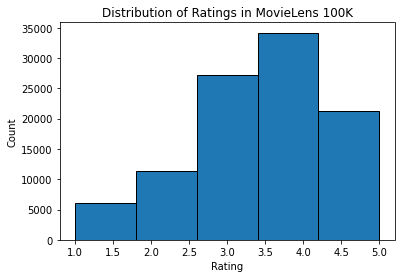

In [4]:
d2l.plt.hist(data['rating'], bins=5, ec='black')
d2l.plt.xlabel("Rating")
d2l.plt.ylabel("Count")
d2l.plt.title("Distribution of Ratings in MovieLens 100K")
d2l.plt.show()

## Splitting the dataset

We split the dataset into training and test sets. The following function provides two split modes including `random` and `seq-aware`. In the `random` mode, the function splits the 100k interactions randomly without considering timestamp and uses the 90% of the data as training samples and the rest 10% as test samples by default. In the `seq-aware` mode, we leave out the item that a user rated most recently for test, and users' historical interactions as training set.  User historical interactions are sorted from oldest to newest based on timestamp. This mode will be used in the sequence-aware recommendation section.

In [5]:
# Saved in the d2l package for later use
def split_data_ml100k(data, num_users, num_items,
               split_mode="random", test_ratio = 0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == "seq-aware":
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u,[]).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

Note that it is good practice to use a validation set in practice, apart from only a test set. However, we omit that for the sake of brevity. In this case, our test set can be regarded as our held-out validation set.

## Loading the data

After dataset splitting, we will convert the training set and test set into lists and dictionaries/matrix for the sake of convenience. The following function reads the dataframe line by line and enumerates the index of users/items start from zero. The function then returns lists of users, items, ratings and a dictionary/matrix that records the interactions. We can specify the type of feedback to either `explicit` or `implicit`.

In [6]:
# Saved in the d2l package for later use
def load_data_ml100k(data, num_users, num_items, feedback="explicit"):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == "explicit" else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == "explicit" else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == "implicit":
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

Afterwards, we put the above steps together and it will be used in the next section. The results are wrapped with `Dataset` and `DataLoader`. Note that the `last_batch` of `DataLoader` for training data is set to the `rollover` mode (The remaining samples are rolled over to the next epoch.) and orders are shuffled.

In [7]:
# Saved in the d2l package for later use
def split_and_load_ml100k(split_mode="seq-aware", feedback="explicit",
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    train_set = gluon.data.ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = gluon.data.ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = gluon.data.DataLoader(
        train_set, shuffle=True, last_batch="rollover",
        batch_size=batch_size)
    test_iter = gluon.data.DataLoader(
        test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

## Summary

* MovieLens datasets are widely used for recommendation research. It is public available and free to use.
* We define functions to download and preprocess the MovieLens 100k dataset for further use in later sections.


## Exercises

* What other similar recommendation datasets can you find?
* Go through the [https://movielens.org/](https://movielens.org/) site for more information about MovieLens.